In [1]:
import os
from datetime import datetime
import json
import pandas as pd

import tensorflow as tf
print(tf.__version__)
import numpy as np
from sklearn.preprocessing import normalize, MinMaxScaler

import matplotlib.pyplot as plt

2.3.0


# Utils (Copied)

In [2]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  # series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)
def model_forecast(model, series, window_size, batch_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(batch_size).prefetch(1)
  forecast = model.predict(ds)
  return forecast

def plot_series(time, series, format="-", start=0, end=None, currtype ='exalted'):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

# Load data

In [3]:
dir = '/content/drive/My Drive/ColabData/POEData/'
os.listdir(dir)

['Metamorph.2019-12-13.2020-03-09.currency.csv',
 'Metamorph.2019-12-13.2020-03-09.items.csv',
 'Blight.2019-09-06.2019-12-09.currency.csv',
 'Blight.2019-09-06.2019-12-09.items.csv',
 'Legion.2019-06-07.2019-09-02.currency.csv',
 'Legion.2019-06-07.2019-09-02.items.csv',
 'Synthesis.2019-03-08.2019-06-04.currency.csv',
 'Synthesis.2019-03-08.2019-06-04.items.csv',
 'Betrayal.2018-12-07.2019-03-05.items.csv',
 'Betrayal.2018-12-07.2019-03-05.currency.csv',
 'Delve.2018-08-31.2018-12-03.currency.csv',
 'Delve.2018-08-31.2018-12-03.items.csv',
 'Incursion.2018-06-01.2018-08-28.items.csv',
 'Incursion.2018-06-01.2018-08-28.currency.csv',
 'Delirium.2020-03-13.2020-06-15.items.csv',
 'Delirium.2020-03-13.2020-06-15.currency.csv',
 'exalteddf.csv',
 'exaltedorbmodel.h5',
 'divinedf.csv',
 'items.json',
 'allitems.csv']

In [4]:
df_items = pd.read_csv(dir+'allitems.csv')

In [5]:
START_DATE = '2018-12-07'
START_DATE = datetime.strptime(START_DATE, '%Y-%m-%d')

df_items['Date'] = pd.to_datetime(df_items['Date'])
df_items['Day_Diff'] = (df_items['Date']-START_DATE).dt.days
df_items = df_items[df_items['Day_Diff'] >= 0]

In [6]:
df_items

,Unnamed: 0,League,Date,Id,Type,Name,BaseType,Variant,Links,Value,Confidence,Day_Diff
1914,42096,Betrayal,2018-12-07,18978,DivinationCard,The Nurse,NaN,NaN,NaN,74.00000,Low,0
1915,42097,Betrayal,2018-12-08,18978,DivinationCard,The Nurse,NaN,NaN,NaN,16.00000,High,1
1916,42098,Betrayal,2018-12-09,18978,DivinationCard,The Nurse,NaN,NaN,NaN,24.00000,High,2
1917,42099,Betrayal,2018-12-10,18978,DivinationCard,The Nurse,NaN,NaN,NaN,37.34633,High,3
1918,42100,Betrayal,2018-12-11,18978,DivinationCard,The Nurse,NaN,NaN,NaN,40.00000,High,4
...,...,...,...,...,...,...,...,...,...,...,...,...
9115,80941,Delirium,2020-06-11,1524,DivinationCard,The Hoarder,NaN,NaN,NaN,10.00000,High,552
9116,80942,Delirium,2020-06-12,1524,DivinationCard,The Hoarder,NaN,NaN,NaN,10.00000,High,553
9117,80943,Delirium,2020-06-13,1524,DivinationCard,The Hoarder,NaN,NaN,NaN,10.00000,High,554
9118,80944,Delirium,2020-06-14,1524,DivinationCard,The Hoarder,NaN,NaN,NaN,10.00000,High,555


In [7]:
# Load JSON items file
with open(dir+'items.json') as f:
  ITEMS = json.load(f)
print(ITEMS.keys())

dict_keys(['nurse', 'doctor', '7yrs', 'immortal', 'homirrors', 'bard', 'atzmirror', '6linkproph', 'ambushproph', 'twiceench', '10ex', '3ex', '2ex', '1ex'])


In [8]:
ITEMS_SUBSET = {
    'maxvaluecards':['nurse', 'doctor','7yrs','immortal','homirrors'],
    'excards':['10ex','3ex','2ex','1ex'],
    'others':['bard','atzmirror','6linkproph','ambushproph','twiceench']
}

# Analyze Data

In [9]:
time = {}
series = {}

# Items
for key, itemname in ITEMS.items():
  itemdf = df_items
  time[key] = itemdf[itemdf['Name']==itemname]['Day_Diff'].values
  series[key] = itemdf[itemdf['Name']==itemname]['Value'].values

In [10]:
# Generate wanted subset of series

subsets = {}
subsett = {}

for key, itemsubset in ITEMS_SUBSET.items():
  series_subset = {}
  time_subset = {}
  for itemname in itemsubset:
    series_subset[itemname] = series[itemname]
    time_subset[itemname] = time[itemname]
  subsets[key] = series_subset
  subsett[key] = time_subset


In [11]:
def padseries(series, time, padlength=600):
  for key, value in series.items():
    if series[key].shape[0] < MAXPAD:
      series[key] = np.pad(series[key], (MAXPAD-series[key].shape[0], 0), mode='constant', constant_values=0)
    if time[key].shape[0] < MAXPAD:
      time[key] = np.pad(time[key], (MAXPAD-time[key].shape[0], 0), mode='constant', constant_values=0)
  return series, time

In [12]:
# PAD
MAXPAD = 600

for key, sersub in subsets.items():
  subsets[key], subsett[key] = padseries(sersub, subsett[key], MAXPAD)


In [13]:
print(subsets.keys())
print(subsets['excards']['1ex'].shape)

dict_keys(['maxvaluecards', 'excards', 'others'])
(600,)


In [14]:
stacked_series = {}
stacked_time = {}

for key, sersub in subsets.items():
  stacked_series[key] = np.stack([sersub[k] for k,v in sersub.items()], axis=-1)
  stacked_time[key] = np.stack([subsett[key][k] for k,v in subsett[key].items()], axis=-1)

In [15]:
SPLIT = 510

time_train = {}
x_train = {}
time_valid = {}
x_valid = {}

for key, sersub in subsets.items():
  time_train[key] = stacked_time[key][:SPLIT,:]
  x_train[key] = stacked_series[key][:SPLIT,:]
  time_valid[key] = stacked_time[key][SPLIT:,:]
  x_valid[key] = stacked_series[key][SPLIT:,:]

# Build Deep Learning Model


In [16]:
class dlmodel():
  def __init__(self, series, x_train, window_size, batch_size, shuffle_buffer, epochs, learning_rate=1e-4, seed=51, model_name=None):

    tf.random.set_seed(seed)
    np.random.seed(seed)

    self.series = series
    self.x_train = x_train
    self.window = window_size
    self.batch_size = batch_size
    self.shuffbuff = shuffle_buffer
    self.epochs = epochs
    self.learn_rate = learning_rate
    self.history = None

    inputsize = self.x_train.shape[1]

    self.model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu', input_shape=[None, inputsize]),
                                    tf.keras.layers.LSTM(128, return_sequences=True),
                                    tf.keras.layers.LSTM(128, return_sequences=True),
                                    tf.keras.layers.LSTM(128, return_sequences=True),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(32, activation='relu'),
                                    tf.keras.layers.Dense(16, activation='relu'),
                                    tf.keras.layers.Dense(inputsize),
                                    tf.keras.layers.Lambda(lambda x: x*400)
    ], name=model_name)

    self.lr_schedule = tf.keras.callbacks.LearningRateScheduler(self.lrscheduler)
    self.optim = tf.keras.optimizers.Adam(lr=self.learn_rate)
    self.model.compile(loss=tf.keras.losses.Huber(), optimizer=self.optim, metrics=['mae'])
    
    self.getSummary()

    self.train_set = windowed_dataset(self.x_train, self.window, self.batch_size, self.shuffbuff)

  def lrscheduler(self, epoch, lr):
    scheduler = [400, 750, 1400]
    if epoch in scheduler:
      return lr/3
    else:
      return lr

  def getSummary(self):
    self.model.summary()
  
  def train(self, epochs=None):
    if not epochs:
      epochs = self.epochs
    self.history = self.model.fit(self.train_set, epochs=epochs, callbacks=[self.lr_schedule])

  def plottrain(self):
    plt.plot(range(self.epochs), self.history.history["loss"])
    plt.plot(range(self.epochs), self.history.history["mae"])
    diff = []
    for i in range(len(self.history.history["loss"])):
      diff.append(self.history.history["mae"][i]-self.history.history["loss"][i])

    # plt.axis([0, self.epochs, 1, 2.5])


    plt.figure(2)
    plt.plot(range(self.epochs), diff)

    plt.figure(3)
    plt.semilogx(self.history.history["lr"], self.history.history["loss"])
    # plt.axis([1e-6, 1e-1, 0, 0.5])

  def predict(self):
    rnn_forecast = model_forecast(self.model, self.series, self.window, self.batch_size)
    return rnn_forecast

In [17]:
WINDOW = 5
BATCH = 32
SHUFFLE_BUFFER = 100
EPOCHS = 2000


models = {}
key = 'excards'
models[key] = dlmodel(series = stacked_series[key],
                      x_train = x_train[key], 
                      window_size = WINDOW, 
                      batch_size = BATCH, 
                      shuffle_buffer = SHUFFLE_BUFFER,
                      epochs = EPOCHS, 
                      model_name = key)

Model: "excards"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 64)          832       
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         98816     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
dense (Dense)                (None, None, 64)          8256      
_________________________________________________________________
dense_1 (Dense)              (None, None, 32)          2080      
_________________________________________________________________
dense_2 (Dense)              (None, None, 16)          528 

Epoch 1/2000
16/16 [==============================] - 0s 12ms/step - loss: 55.0872 - mae: 55.5386
Epoch 2/2000
16/16 [==============================] - 0s 10ms/step - loss: 50.9160 - mae: 51.4065
Epoch 3/2000
16/16 [==============================] - 0s 11ms/step - loss: 46.9164 - mae: 47.4087
Epoch 4/2000
16/16 [==============================] - 0s 11ms/step - loss: 42.9358 - mae: 43.4227
Epoch 5/2000
16/16 [==============================] - 0s 11ms/step - loss: 39.4427 - mae: 39.9310
Epoch 6/2000
16/16 [==============================] - 0s 11ms/step - loss: 36.2514 - mae: 36.7379
Epoch 7/2000
16/16 [==============================] - 0s 11ms/step - loss: 32.5527 - mae: 33.0364
Epoch 8/2000
16/16 [==============================] - 0s 11ms/step - loss: 27.8555 - mae: 28.3335
Epoch 9/2000
16/16 [==============================] - 0s 9ms/step - loss: 21.9236 - mae: 22.4025
Epoch 10/2000
16/16 [==============================] - 0s 9ms/step - loss: 18.7350 - mae: 19.2166
Epoch 11/2000
16/16 [

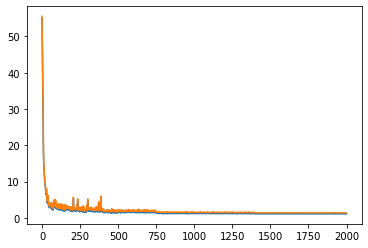

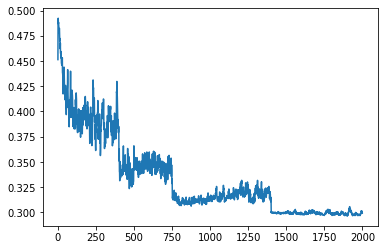

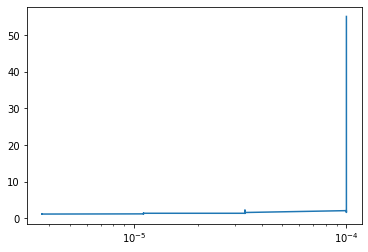

In [18]:
# Train model
models[key].train()
models[key].plottrain()



In [28]:
rnn_forecast = models[key].predict()
rnn_forecast = rnn_forecast[SPLIT - WINDOW:-1, -1, :]
# rnn_forecast[0,:] = 0

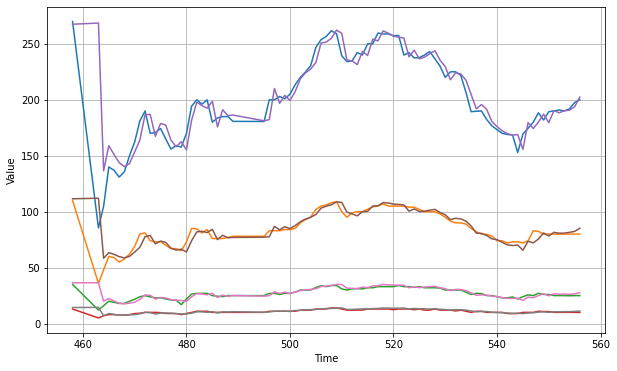

In [29]:
START_ITEM = 0
END_ITEM = None

plt.figure(figsize=(10, 6))
plot_series(time_valid[key][:,START_ITEM:END_ITEM], x_valid[key][:,START_ITEM:END_ITEM])
plot_series(time_valid[key][:,START_ITEM:END_ITEM], rnn_forecast[:,START_ITEM:END_ITEM])

In [37]:
START = 2
END = None

print(tf.keras.metrics.mean_squared_error(x_valid[key][START:END,1], rnn_forecast[START:END,1]).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid[key][START:END,1], rnn_forecast[START:END,1]).numpy())

14.072489
2.7006476


# Save Model

In [38]:
models['excards'].model.save(dir+'excardsmodel.h5')